# Harpy support for Instanseg segmentation model

This notebook provides a minimal example to show how to run [Instanseg](https://github.com/instanseg/instanseg), a pytorch based cell and nucleus segmentation pipeline for fluorescent and brightfield microscopy images. More information here:

Goldsborough, T. et al. (2024) ‘A novel channel invariant architecture for the segmentation of cells and nuclei in multiplexed images using InstanSeg’. bioRxiv, p. 2024.09.04.611150. Available at: https://doi.org/10.1101/2024.09.04.611150.

## Run Instanseg example code

This is a minimal example to show how to run the code and notebook provided in the [Instanseg](https://github.com/instanseg/instanseg/blob/main/notebooks/segmentation_minimal.ipynb) repository.


In [1]:
# make sure to install the instanseg dependencies in setup.cfg
# pip install -e '.[instanseg]'

In [2]:
from sparrow.datasets.proteomics import read_tifffile
from sparrow.datasets.registry import get_ome_registry

registry=get_ome_registry( path = None )  # if path is None, example .tif will be downloaded in the default cache folder of your os.
path = registry.fetch("Vectra-QPTIFF/perkinelmer/PKI_fields/LuCa-7color_%5b13860,52919%5d_1x1component_data.tif")

image_data, physical_pixel_size_x, physical_pixel_size_y =read_tifffile( path )
assert physical_pixel_size_x == physical_pixel_size_y

pixel_size = physical_pixel_size_x
print( f"Physical pixel size is {pixel_size} μm." )
print( f"image dimensions are (c,y,x): {image_data.shape}." )

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


Physical pixel size is 0.49799447890790055 μm.
image dimensions are (c,y,x): (8, 1400, 1868).


In [3]:
import os
import tempfile
from pathlib import Path

import torch
from InstanSeg.utils.utils import _choose_device, download_model

# Call the function to download and extract the models

model_to_download = "fluorescence_nuclei_and_cells"  # or "brightfield_nuclei"

# CHANGE this to path where you would like to download the instanseg model.
model_path = tempfile.gettempdir()

path_to_torchscript_model = Path(os.path.join( model_path, f"{model_to_download}/instanseg.pt" ))
if not path_to_torchscript_model.exists():
    download_model(model_to_download)
# Load the model from torchscript, replace "instanseg.pt" with the name of your model.
instanseg = torch.jit.load(path_to_torchscript_model)

device = _choose_device()
instanseg.to(device)

model_pixel_size = instanseg.pixel_size

print( f"Instanseg physical pixel size is {model_pixel_size} μm" )

Requesting default device: mps
Instanseg physical pixel size is 0.5 μm


In [4]:
from InstanSeg.utils.augmentations import Augmentations

Augmenter = Augmentations()

input_tensor, _ = Augmenter.to_tensor(image_data, normalize=False)  # this converts the input data to a tensor
input_tensor, _ = Augmenter.normalize(input_tensor, percentile=0.1)
original_shape = input_tensor.shape[1:]
print(input_tensor.shape)

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([8, 1400, 1868])


In [5]:
# This rescales the input to the requested pixel size (0.5 microns).
# For display purposes only
input_tensor_to_rgb, _ = Augmenter.colourize(
    input_tensor, c_nuclei=6, random_seed=1
)  # c_nuclei is the index of the nucleus channel in the input (nucleus channel is in blue by default in the display image)


input_crop, _ = Augmenter.torch_rescale(
    input_tensor,
    labels=None,
    current_pixel_size=pixel_size,
    requested_pixel_size=model_pixel_size,
    crop=True,
    random_seed=1,
)
input_tensor, _ = Augmenter.torch_rescale(
    input_tensor,
    labels=None,
    current_pixel_size=pixel_size,
    requested_pixel_size=model_pixel_size,
    crop=False,
    random_seed=1,
)
input_crop_to_rgb, _ = Augmenter.colourize(input_crop, c_nuclei=6, random_seed=1)

In [6]:
# To run instanseg in one pass, you can simply call the model with the input tensor. (No tiling)

# Make sure the input tensor is of shape 1, C, H, W.

labeled_output = instanseg(
    input_crop.to(device)[None]
)  # The labeled_output shape should be 1,1,H,W (nucleus or whole cell) or 1,2,H,W (nucleus and whole cell)
output_dimension = labeled_output.shape[1]
print(labeled_output.shape)

torch.Size([1, 2, 256, 256])


/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/torch/nn/modules/module.py:1562: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return forward_call(*args, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020928286..1.3205023].


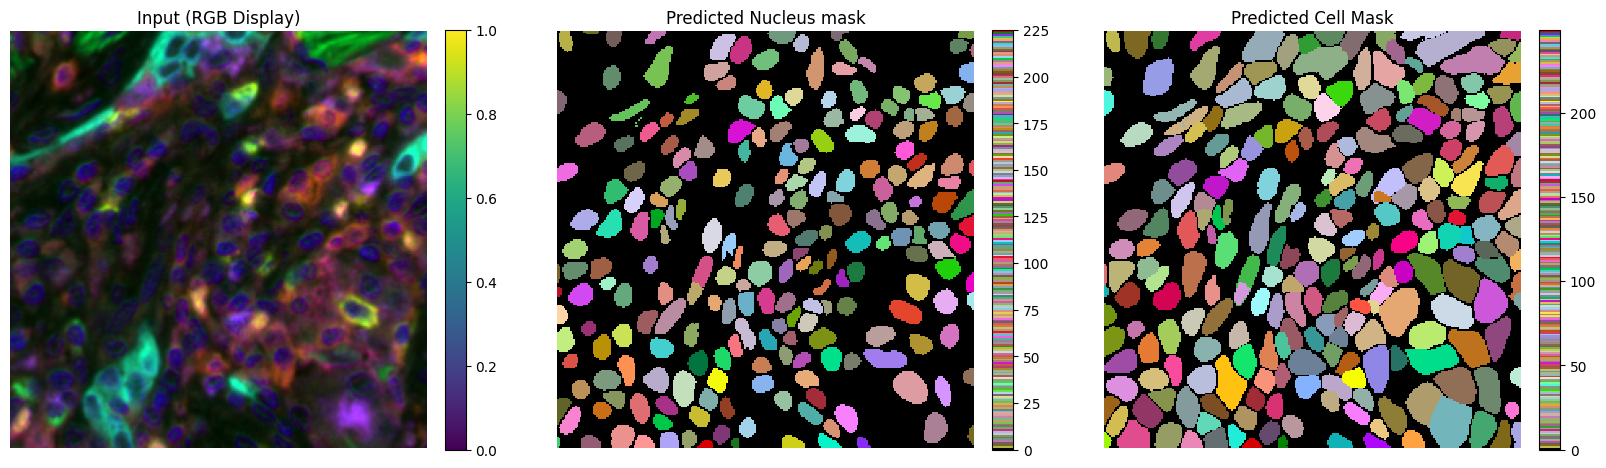

In [7]:
from InstanSeg.utils.utils import show_images

if output_dimension == 1:  # Nucleus or cell mask]
    show_images(
        input_crop_to_rgb,
        labeled_output[0, 0],
        labels=[1],
        colorbar=False,
        titles=["Input (RGB Display)", "Predicted mask"],
        dpi=100,
    )
elif output_dimension == 2:  # Nucleus and cell mask
    show_images(
        input_crop_to_rgb,
        labeled_output[0, 0],
        labeled_output[0, 1],
        labels=[1, 2],
        colorbar=True,
        titles=["Input (RGB Display)", "Predicted Nucleus mask", "Predicted Cell Mask"],
        dpi=100,
    )

## Run Harpy with Instanseg support

This is the same example, but using the Harpy library to run the code. The same model is loaded from the Instanseg repository and the code is executed on SpatialData objects.

- The same dataset is used, loaded in SpatialData using `datasets.vectra_example`.
- You can either run the segmentation model directly or run via the Harpy segment function.


In [8]:
import sparrow as sp
import spatialdata_plot

In [9]:
from sparrow.datasets import vectra_example

sdata = vectra_example()
sdata

SpatialData object
└── Images
      └── 'image': DataArray[cyx] (8, 1400, 1868)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010349865436370627..1.087689350249904].


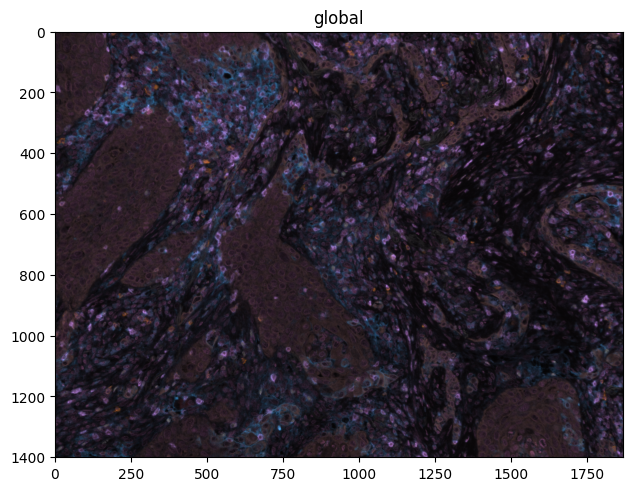

In [10]:
sdata.pl.render_images("image").pl.show()

### Run just the `InstanSeg` model

The InstanSeg model is implementated as a Harpy segmentation model. It can be called like a function using the right arguments and segment the image.

A caveat is that Harpy segmentation models use data formatted as `(z, y, x, c)` as both input and output. The code above and the data in SpatialData objects is ordered as `(c, y, x)`.

In [11]:
from sparrow.image.segmentation.segmentation_models._instanseg import _instanseg

In [12]:
sdata["image"]

<xarray.DataArray 'image' (c: 8, y: 1400, x: 1868)> Size: 84MB
dask.array<array, shape=(8, 1400, 1868), dtype=float32, chunksize=(8, 1400, 1868), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 64B 0 1 2 3 4 5 6 7
  * y        (y) float64 11kB 0.5 1.5 2.5 3.5 ... 1.398e+03 1.398e+03 1.4e+03
  * x        (x) float64 15kB 0.5 1.5 2.5 3.5 ... 1.866e+03 1.866e+03 1.868e+03
Attributes:
    transform:  {'global': Identity }

In [13]:
import numpy as np

# add an empty Z dimension and put the C dimension last
arr = np.transpose(sdata["image"].to_numpy()[None, ...], [0, 2, 3, 1])
arr.shape

(1, 1400, 1868, 8)

In [14]:
# run the model, specify 'all' if you want to obtain nuclei and whole cell masks.
output_arr = _instanseg(arr, instanseg_model=instanseg, output="all", device=device)
print( output_arr.shape )  #( z,y,x,c )

(1, 1400, 1868, 2)


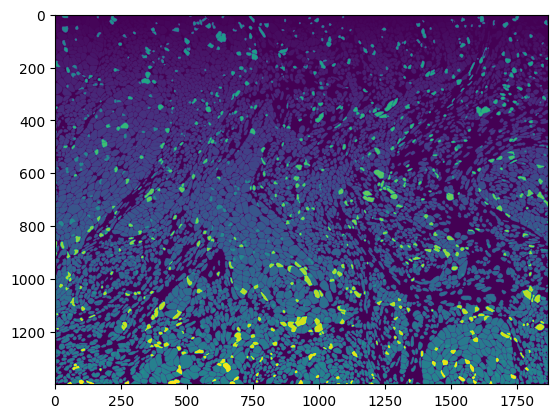

In [15]:
import matplotlib.pyplot as plt

plt.imshow(output_arr[0, ..., 1]) # plot whole cell masks

## Run Instanseg using the Harpy `segment` function

This is the most convenient function to run the model. It takes care of loading the model, running the segmentation on large images and returning the results in a `SpatialData` object as a Labels element.

An important caveat is that now the segmentation process is parallellized in chunks. By providing the `instanseg_model` to the function, we prevent every call from loading the same model and blowing up memory usage.

The resulting segmentation plot is similar as the one provided in the InstanSeg notebook.

Let's load the model again.

In [16]:
import os
from pathlib import Path

import torch
from InstanSeg.utils.utils import _choose_device, download_model

# Call the function to download and extract the models

model_to_download = "fluorescence_nuclei_and_cells"  # or "brightfield_nuclei"

model_path = tempfile.gettempdir()

path_to_torchscript_model = Path(os.path.join( model_path, f"{model_to_download}/instanseg.pt" ))
if not path_to_torchscript_model.exists():
    download_model(model_to_download)
# Load the model from torchscript, replace "my_first_instanseg.pt" with the name of your model.
instanseg = torch.jit.load(path_to_torchscript_model)

device = _choose_device()
instanseg.to(device)
print("Model loaded")

Requesting default device: mps
Model loaded


In [17]:
from sparrow.image.segmentation.segmentation_models._instanseg import _instanseg

sdata=sp.im.segment(
    sdata=sdata,
    img_layer="image",
    # Only specify one labels layer if output parameter is set to "whole_cell" or "nuclei".
    output_labels_layer=["segmentation_mask_nuclei", "segmentation_mask_whole_cell"],
    output_shapes_layer=None,
    # if parameter labels_layer_align is specified, labels in "segmentation_mask_nuclei" will be aligned with corresponding labels of whole cell masks in "segmentation_mask_whole_cell"
    labels_layer_align="segmentation_mask_whole_cell",
    model=_instanseg,
    # Set output to "nucleus" to get only the nucleus mask, "whole_cell" to get the whole cell mask and 'all' or None to get both "nuclei" and "whole_cell"
    output="all",
    chunks=(512, 512),
    device=device,
    instanseg_model=instanseg,
    overwrite=True,
)

2024-10-14 13:50:31,962 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-10-14 13:50:32,009 - sparrow.image._manager - INFO - Writing results to layer 'segmentation_mask_nuclei'
2024-10-14 13:50:32,010 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-10-14 13:50:32,052 - sparrow.image._manager - INFO - Writing results to layer 'segmentation_mask_whole_cell'
2024-10-14 13:50:32,065 - sparrow.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2024-10-14 13:50:34,091 - sparrow.image._manager - INFO - Writing results to layer 'segmentation_mask_nuclei'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:79: UserWarning: Key `segmentation_mask_nuclei` already exists. Overwriting it in-memory.
  self._chec

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010349865436370627..1.087689350249904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010349865436370627..1.087689350249904].


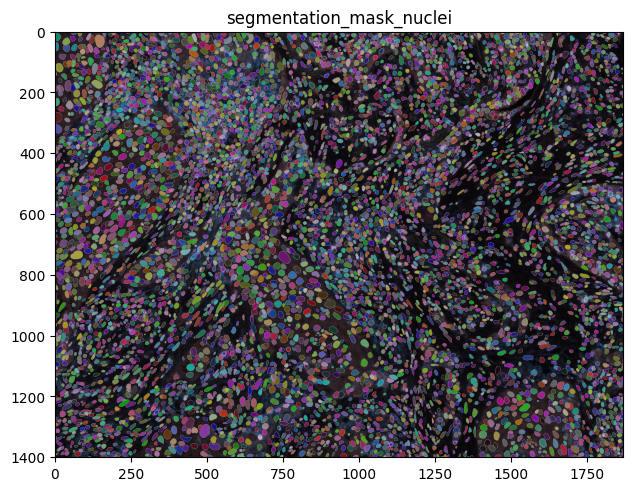

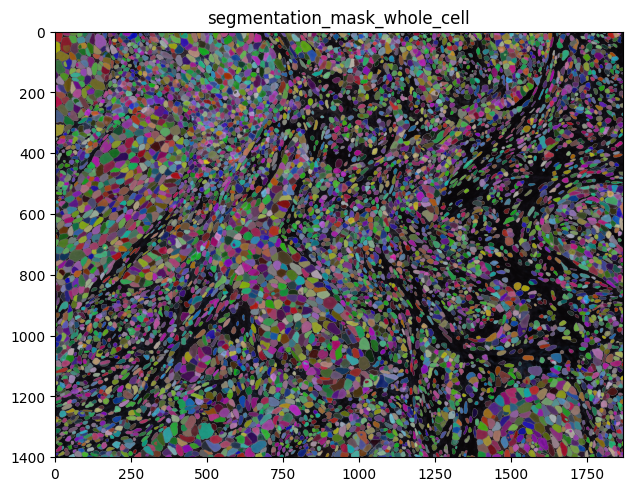

In [18]:
for _labels_layer in ["segmentation_mask_nuclei", "segmentation_mask_whole_cell"]:
    (sdata.pl.render_images("image").pl.render_labels( _labels_layer ).pl.show( title=_labels_layer ))